# Total Data Preprocessing
- Back Translation해서 늘린 전체 데이터를 가지고 진행해야 됨.
- 전체 데이터에는 S_U_B_J도 여러 개 O_B_J도 여러개일 수 있고 없을 수도 있음
- 불린 데이터의 경우는 실제 Entity 위치를 모름(정확히 말하면 원본 데이터에서 바뀌면서 위치가 바뀌었을 수 있음)
- 내가 할 것 
  - 전체 데이터 받아서 Entity Marking진행
  - 늘어난 전체 데이터를 받아서 마스킹(상렬님께 불리고 나서 마스킹이 되어 있는지 물어보기)
  - 늘어난 전체 데이터 전처리 
  - 늘어난 전체 데이터 복원
  - *********인코딩은 이미 S_U_B_J여러개 또는 없음 O_B_J 여러개 또는 없음 경우로 진행했으니, 디코딩 하는 방식을 고민

## 할 것 다시 정리 
1. Entity Marking 하기
2. 데이터 마스킹이 안되어 있다면 마스킹
3. 전처리
4. 원래 데이터로 복원하기(= Entity Marker는 붙은 상태로 마스킹만 없애기)

## Marking할 때 Entity 찾는 방법 고민
원본 데이터는 idx가 변하지 않았기 때문에 idx를 이용해 찾는다.
늘린 데이터나 변형된 데이터에 대해, 다음과 같은 방법을 사용하였다. 
- Subject Entity와 동일한 단어(또는 어구)의 위치를 모두 찾는다. 그 위치들 중 원래 Entity 정보에서의 idx와 가장 가까이 있는 애를 Entity라고 생각한다.
- Object Entity들도 동일하다.

위 방법은 두 가지 가정이 필요하다.
- Back translation, EDA, AEDA 과정에서 Entity는 변형되지 않는다. -> 데이터를 늘릴 당시에 Entity 보호 작업을 진행
- 문장이 변형되었더라도, 원래의 Entity는 후보군들(Entity word와 완전히 일치하는 어구들) 중에서 바뀌기 전 idx위치와 가장 가까운 곳에 위치할 것이다.

## 최종적으로 실험을 위해 넘겨드릴 데이터 후보군
- 원본 데이터(는 다 가지고 계시고)
- 원본 데이터 전처리 후
- 원본 데이터 전처리 후 Entity 꾸미기 후 데이터
- 늘어난 데이터 그대로 (S_U_B_J, O_B_J 가려진 것 없이)
- 늘어난 데이터 전처리 후 데이터
- 늘어난 데이터 전처리 후 Entity 꾸미기 후 데이터
  - Entity 특수문자로 꾸미기

## 진행!

In [93]:
import pandas as pd
import re

In [94]:
train_df = pd.read_csv('../dataset/train/train.csv')

In [ ]:
train_df

### 1. Entity Mark

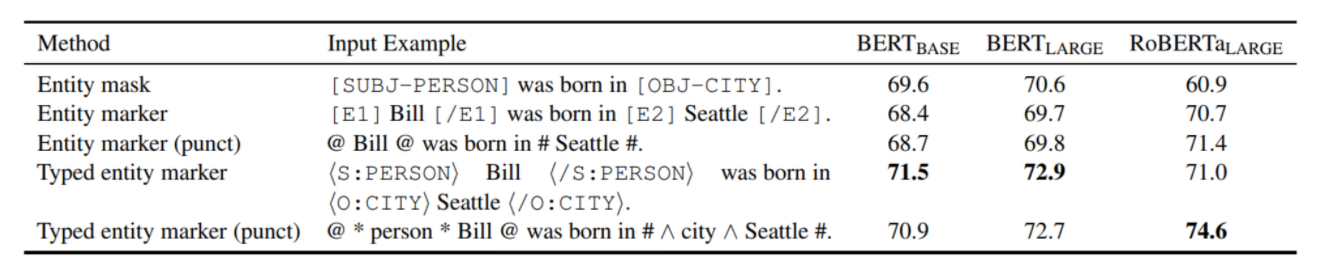

#### 1-1. Entity 표시할 특수 문자 정하기
- 다른 문장들에는 없는 것으로 추가 
- EDA, AEDA에서는 좀 달라질 수 있음

In [113]:
sentence = list(train_df['sentence'])
for s in sentence:
    if re.search(r'[\@\+\#\^]+', s):
        print(s)

#### 1-2. Entity 위치 찾기 & Marking (*주의 * Masking아님 Marking임. 위의 표)
- 원본 데이터이면 idx로 찾으면 되고,
- 변현된 데이터이면 idx 근처에서 찾기

In [106]:
SUBJ_TOKEN = 'S_U_B_J'
OBJ_TOKEN = 'O_B_J'

def entity_marking(entity:str, is_subj:bool, marker_type:str): # entity는 Entity에 대한 dictionary 정보로 받는다. (type도 필요하기 때문)
    word, word_type = eval(entity)['word'], eval(entity)['type']
    
    marked_word = ''
    if marker_type == "entity_marker": # --> [E1] Bill [/E1] was born in [E2] Seattle [/E2].
        if is_subj:
            marked_word = '[E1]' + word + '[/E1]'
        else:
            marked_word = '[E2]' + word + '[/E2]'
            
    elif marker_type == "entity_marker_punc": # --> @ Bill @ was born in # Seattle #.
        if is_subj:
            marked_word = '@' + word + '@'
        else:
            marked_word = '#' + word + '#'
            
    elif marker_type == "typed_entity_marker":# --> <S:PERSON> Bill </S:PERSON> was born in <O:CITY> Seattle </O:CITY>
        if is_subj:
            marked_word = f'<S:{word_type}>' + word + f'</S:{word_type}>' 
        else:
            marked_word = f'<O:{word_type}>' + word + f'</O:{word_type}>' 
            
    elif marker_type == "typed_entity_marker_punc": # --> @ +person+ Bill @ was born in #^city^ Seattle #.
        if is_subj:
            marked_word = f'@+{word_type}+' + word + '@'
        else:
            marked_word = f'#^{word_type}^' + word + '#'
    return marked_word
        
# main함수      
def get_entity_marked_data(train_df : pd.DataFrame, marker_type_num : int):
    assert type(marker_type_num)==int and marker_type_num in [0, 1, 2, 3], "marker type number를 확인하세요. (0: entity_marker, 1:entity_marker_punc, 2:typed_entity_marker, 3:typed_entity_marker_punc)"
    
    train_df_entity_marked = pd.DataFrame(columns = ['id' , 'sentence', 'subject_entity', 'object_entity', 'label', 'source'])

    for i, data in enumerate(train_df.iloc):
        data_dict = dict(data)
        i_d, sentence, subj, obj, label, source = data_dict.values()
        subj_word, subj_start, subj_end, subj_type = eval(subj).values()
        obj_word, obj_start, obj_end, obj_type = eval(obj).values()

        # 1. Entity Marker 방식
        marker_types = ["entity_marker", "entity_marker_punc", "typed_entity_marker", "typed_entity_marker_punc"]
        marker_type = marker_types[marker_type_num-1] # marker type num 바꾸면 이 부분이 바뀐다.
        
        # 2. Entity 찾기 
        if subj_word != sentence[subj_start: subj_end+1]: 
            '''(똑같은 단어들 중 원래 idx와 가장 가까이 있는 애를 진짜 entity라고 생각)'''
            candidates = re.finditer(subj_word, sentence)
            closest_one = min(candidates, key=lambda x: abs(x.start()-subj_start)+abs(x.end()-(subj_end+1)))
            subj_start, subj_end = closest_one.start(), closest_one.end()-1
            
        # 3. Entity 찾기
        if obj_word != sentence[obj_start: obj_end+1]: 
            '''(똑같은 단어들 중 원래 idx와 가장 가까이 있는 애를 진짜 entity라고 생각)'''
            candidates = re.finditer(obj_word, sentence)
            closest_one = min(candidates, key=lambda x: abs(x.start()-obj_start)+abs(x.end()-(obj_end+1)))
            obj_start, obj_end = closest_one.start(), closest_one.end()-1
            
        # 4. Entity 표시 -> subj, obj 한 번에 해야 idx로 할 수 있음
        if subj_end < obj_start:
            sentence = sentence[:subj_start] \
                        + entity_marking(entity=subj, is_subj=True, marker_type=marker_type) \
                        + sentence[subj_end+1:obj_start]\
                        + entity_marking(entity=obj, is_subj=False, marker_type=marker_type) \
                        + sentence[obj_end+1:]
        elif obj_end < subj_start: 
            sentence = sentence[:obj_start] \
                        + entity_marking(entity=obj, is_subj=False, marker_type=marker_type) \
                        + sentence[obj_end+1:subj_start]\
                        + entity_marking(entity=subj, is_subj=True, marker_type=marker_type) \
                        + sentence[subj_end+1:]
            
        # 5. 가공한 데이터 추가
        train_df_entity_marked.loc[i] = [i_d, sentence, subj, obj, label, source]
    return train_df_entity_marked

In [189]:
# marker_types -> 1: "entity_marker", 2:"entity_marker_punc", 3: "typed_entity_marker", 4: "typed_entity_marker_punc"]
train_df_entity_marked = get_entity_marked_data(train_df=train_df, marker_type_num=1)

In [ ]:
train_df_entity_marked

In [116]:
sentence_marked = list(train_df_entity_marked['sentence'])
for s in sentence_marked:
    if '[E1]'not in s or '[/E1]' not in s or '[E2]'not in s or '[/E2]' not in s :
        print(s)

#### 1-3. Special Token 추가

- 1번, 3번은 Special Token 추가 필요
- 2번, 4번은 사전에 없으면 추가 필요

##### [Test]

In [188]:
from transformers import AutoTokenizer

In [175]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

In [ ]:
tokenizer.tokenize(sentence_marked[0], add_special_tokens=True) # 헉 '#'은 marker로 안될 수도 있겠다.

In [177]:
tokenizer.special_tokens_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [178]:
sub_obj = ["[E1]", "[/E1]","[E2]", "[/E2]"]
#dir(tokenizer)
added_token_num = tokenizer.add_special_tokens({ "additional_special_tokens": sub_obj})

In [179]:
tokenizer.special_tokens_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']}

In [ ]:
tokenizer.tokenize(sentence_marked[0], add_special_tokens=True)

##### [Function]

In [190]:
entity_only_df = pd.read_csv('../dataset/train/train_only_entity.csv')

In [191]:
entity_only_df['subj_type'].value_counts()

PER    16786
ORG    15684
Name: subj_type, dtype: int64

In [192]:
entity_only_df['obj_type'].value_counts()

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: obj_type, dtype: int64

In [193]:
entity_only_df_test = pd.read_csv('../dataset/test/test_only_entity.csv')

In [194]:
entity_only_df_test['subj_type'].value_counts()

PER    3925
ORG    3839
LOC       1
Name: subj_type, dtype: int64

In [195]:
entity_only_df_test['obj_type'].value_counts()

POH    3171
LOC    1204
PER    1138
ORG    1047
DAT     790
NOH     415
Name: obj_type, dtype: int64

In [ ]:
from transformers import AutoTokenizer
def add_special_token(marker_type_num=1):
    tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
    
    marker_types = ["entity_marker", "entity_marker_punc", "typed_entity_marker", "typed_entity_marker_punc"]
    marker_type = marker_types[marker_type_num-1]
    
    if marker_type == "entity_marker": # --> [E1] Bill [/E1] was born in [E2] Seattle [/E2].
        markers = ["[E1]", "[/E1]","[E2]", "[/E2]"]
        added_token_num = tokenizer.add_special_tokens({"additional_special_tokens": markers})
    
    elif marker_type == "entity_marker_punc": # --> @ Bill @ was born in # Seattle #.
        markers = ["@", "#"]
        added_token_num = tokenizer.add_special_tokens({"additional_special_tokens": markers})
    
    elif marker_type == "typed_entity_marker": # --> <S:PERSON> Bill </S:PERSON> was born in <O:CITY> Seattle </O:CITY>
        entity_types = ['PER', 'ORG', 'POH', 'DAT', 'LOC', 'NOH']
        markers = []
        for word_type in entity_types:
            sub_obj.append(f'<S:{word_type}>')
            sub_obj.append(f'</S:{word_type}>')
            sub_obj.append(f'<O:{word_type}>')
            sub_obj.append(f'</O:{word_type}>')
        added_token_num = tokenizer.add_special_tokens({"additional_special_tokens": markers})
        
    elif marker_type == "typed_entity_marker_punc":  # --> @ +person+ Bill @ was born in #^city^ Seattle #.
        entity_types = ['PER', 'ORG', 'POH', 'DAT', 'LOC', 'NOH']
        markers = []
        for word_type in entity_types:
            sub_obj.append(f'@+{word_type}+')
            sub_obj.append(f'#^{word_type}^')
        sub_obj.append('@')
        sub_obj.append('#')
        added_token_num = tokenizer.add_special_tokens({"additional_special_tokens": markers})
        
    return added_token_num, tokenizer

In [ ]:
added_token_num, tokenizer = add_special_token(marker_type_num=1)
model.resize_token_embeddings(len(tokenizer))

#### 1-4.Tokenizer로 잘 되었는지 확인

##### 전체 데이터 tokenize 시도 (소연님 코드 참고)

In [181]:
def preprocessing_dataset(dataset):
    """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []
    for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
        i = i[1:-1].split(',')[0].split(':')[1]
        j = j[1:-1].split(',')[0].split(':')[1]
        #print(i, j)
        subject_entity.append(i)
        object_entity.append(j)
    out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entity,'object_entity':object_entity,'label':dataset['label'],})
    return out_dataset

def load_data(dataset_dir):
    """ csv 파일을 경로에 맡게 불러 옵니다. """
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)
  
    return dataset

In [182]:
train_df_entity_marked.to_csv('../dataset/train/train_entity_marked.csv')
loaded_dataset = load_data('../dataset/train/train_entity_marked.csv')

In [183]:
def tokenize_data(dataset, tokenizer):
    """ tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    i=0
    for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
        
        # 과정 확인용 코드(없애도 됨)
        if i< 10 : 
            print(e01, e02)
            i+=1
        
    tokenized_sentences = tokenizer(
                          concat_entity,
                          list(dataset['sentence']),
                          return_tensors="pt",
                          padding=True,
                          truncation=True,
                          max_length=256,
                          add_special_tokens=True,
                          )
    return tokenized_sentences

In [ ]:
tokenized_dataset = tokenize_data(loaded_dataset, tokenizer)

In [185]:
tokenized_dataset

{'input_ids': tensor([[    0,    11, 29830,  ...,     1,     1,     1],
        [    0,    11,  3772,  ...,     1,     1,     1],
        [    0,    11,  4104,  ...,     1,     1,     1],
        ...,
        [    0,    11, 18272,  ...,     1,     1,     1],
        [    0,    11, 15710,  ...,     1,     1,     1],
        [    0,    11, 15437,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [186]:
tokenizer.special_tokens_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']}

In [187]:
print(*tokenized_dataset[0].tokens)
print(*tokenized_dataset[0].special_tokens_mask)

[CLS] ' 비틀즈 ' [SEP] ' 조지 해리 ##슨 ' [SEP] 〈 So ##me ##th ##ing 〉 는 [E2] 조지 해리 ##슨 [/E2] 이 쓰 ##고 [E1] 비틀즈 [/E1] 가 1969 ##년 앨범 《 Ab ##be ##y Ro ##ad 》 에 담 ##은 노래 ##다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

#### 1-5. Entity Embedding 추가

Entity Embedding은 baseline code 모델 부분을 수정할 예정입니다.

### 2. 데이터 전처리 

#### 2-1. 데이터 마스킹이 안되어 있다면 마스킹

In [4]:
# 아무것도 마스킹 했는지 안했는지 확인 함수
def isSUBJorOBJ(text):
    hanCount = len(re.findall(r'(S_U_B_J)+|(O_B_J)+', text))
    return hanCount > 0

In [5]:
import re

def entity_to_token(train_df : pd.DataFrame):
    if not train_df['sentence'].apply(isSUBJorOBJ).any():
        train_df_entity_masked = pd.DataFrame(columns = ['id' , 'sentence', 'subject_entity', 'object_entity', 'label', 'source'])

        for i, data in enumerate(train_df.iloc):
            data_dict = dict(data)
            i_d, sentence, subj, obj, label, source = data_dict.values()
            #print(i_d, sentence, subj, obj, label, source)

            # sentence에서 entity 찾아서 subj, obj로 교체
            #print(eval(subj)['word'])
            sentence = sentence.replace(eval(subj)['word'], 'S_U_B_J')
            sentence = sentence.replace(eval(obj)['word'], 'O_B_J')

            train_df_entity_masked.loc[i] = [i_d, sentence, subj, obj, label, source]
            #print(train_df_entity_masked)
        return train_df_entity_masked

In [6]:
train_df_entity_marked_masked = entity_to_token(train_df_entity_marked)

#### 2-2. 전처리 코드

Masking 되어 있다 생각하고 진행한다.

In [7]:
import kss
import soynlp
from pykospacing import Spacing
from hanspell import spell_checker

2022-03-28 06:50:39.066924: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-28 06:50:40.409308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-28 06:50:41.277280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 06:50:41.280626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-28 06:50:41.280717: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-28 06:50:41.287916: I tensorflow/stream_executor/plat

In [ ]:
sample_context = list(train_df_masked['sentence'])
sample_context[:20]

In [ ]:
for i, t in enumerate(sample_context):
    if 'O_B_J' not in t or 'S_U_B_J' not in t:
        print(i, t)

#### 불필요한 괄호제거 -> 고치기

In [49]:
#원래 것
def remove_useless_breacket(texts):
    """
    위키피디아 전처리를 위한 함수입니다.
    괄호 내부에 의미가 없는 정보를 제거합니다.
    아무런 정보를 포함하고 있지 않다면, 괄호를 통째로 제거합니다.
    ``수학(,)`` -> ``수학``
    ``수학(數學,) -> ``수학(數學)``
    """
    bracket_pattern = re.compile(r"\((.*?)\)")
    preprocessed_text = []
    for text in texts:
        modi_text = ""
        text = text.replace("()", "")  # 수학() -> 수학
        brackets = bracket_pattern.search(text)
        if not brackets: # 괄호가 없으면
            if text:
                preprocessed_text.append(text)
                continue
        replace_brackets = {}
        # key: 원본 문장에서 고쳐야하는 index, value: 고쳐져야 하는 값
        # e.g. {'2,8': '(數學)','34,37': ''}
        while brackets:
            index_key = str(brackets.start()) + "," + str(brackets.end())
            bracket = text[brackets.start() + 1 : brackets.end() - 1]
            infos = bracket.split(",")
            modi_infos = []
            for info in infos:
                info = info.strip()
                if len(info) > 0:
                    modi_infos.append(info)
            if len(modi_infos) > 0:
                replace_brackets[index_key] = "(" + ", ".join(modi_infos) + ")"
            else:
                replace_brackets[index_key] = ""
            brackets = bracket_pattern.search(text, brackets.start() + 1)
        end_index = 0
        for index_key in replace_brackets.keys():
            start_index = int(index_key.split(",")[0])
            modi_text += text[end_index:start_index]
            modi_text += replace_brackets[index_key]
            end_index = int(index_key.split(",")[1])
        modi_text += text[end_index:]
        modi_text = modi_text.strip()
        if modi_text:
            preprocessed_text.append(modi_text)
    return preprocessed_text

In [46]:
test1 = remove_useless_breacket(sample_context)

In [ ]:
#  ...? 괄호를 더 만드는 문제 발생 -> 수정 필요
changed1 = [(sample_context[i], test1[i]) for i in range(len(sample_context)) if test1[i]!=sample_context[i]]
print('Number of change texts: ', len(changed1))
print()
for (t1, t2) in changed1[:10]:
    print(t1) # 원래  
    print(t2) # 바뀐 것
    print()

비어 있는 괄호랑, 반복되는 괄호만 통째로 지우는 함수로 변경

In [51]:
# 수정된 버전
def remove_useless_breacket_revised(texts): # 수정된 버전
    
    '''--> 비어 있는 괄호랑, 반복되는 괄호만 제거하는 것으로 변경'''
    
    bracket_pattern = re.compile(r"\([^\(\)]*?\)")
    preprocessed_text = []
    for text in texts:
        #print(text)
        modi_text = ""
        text = text.replace("()", "")  # 수학() -> 수학
        brackets = bracket_pattern.finditer(text)
        #print(brackets.next().string)
        if not brackets: # 괄호가 없으면
            if text:
                preprocessed_text.append(text)
                continue
    
        # key: 원본 문장에서 고쳐야하는 index, value: 고쳐져야 하는 값
        # e.g. {'2,8': '(數學)','34,37': ''}
        s_idx, e_idx = 0,0
        last = None
        for b in brackets:
            #print(b[0])
            if last and e_idx==b.start():
                if last == b[0]:
                    #print('yes')
                    text = text[:b.start()] + text[b.end():]
            last = b[0]
            s_idx, e_idx = b.start(), b.end()
        preprocessed_text.append(text)
    return preprocessed_text

In [52]:
test1 = remove_useless_breacket_revised(sample_context)

In [ ]:
changed1 = [(sample_context[i], test1[i]) for i in range(len(sample_context)) if test1[i]!=sample_context[i]]
print('Number of change texts: ', len(changed1))
print()
for (t1, t2) in changed1[:10]:
    print(t1) # 원래  
    print(t2) # 바뀐 것
    print()

#### 문장 부호제거

In [22]:
def clean_punc(texts):
    punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } # "_": "-"만 제거

    preprocessed_text = []
    for text in texts:
        for p in punct_mapping:
            #text = re.sub(rf'?^((O_B_J)|(S_U_B_J)) & {p}', punct_mapping[p], text)
            text = text.replace(p, punct_mapping[p])
        text = text.strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [23]:
test2 = clean_punc(sample_context)

In [ ]:
changed2 = [(sample_context[i], test2[i]) for i in range(len(sample_context)) if test2[i]!=sample_context[i]]
print('Number of change texts: ', len(changed2))
print()
for (t1, t2) in changed2[:10]:
    print(t1) # 원래
    print(t2) # 바뀐 것
    print()

#### 연속 공백 제거 - 데이터에 연속 공백 없음 

In [25]:
def remove_repeated_spacing(texts):
    """
    두 개 이상의 연속된 공백을 하나로 치환합니다.
    ``오늘은    날씨가   좋다.`` -> ``오늘은 날씨가 좋다.``
    """
    preprocessed_text = []
    for text in texts:
        text = re.sub(r"\s+", " ", text).strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [31]:
test3 = remove_repeated_spacing(sample_context)

In [32]:
changed3 = [(sample_context[i], test3[i]) for i in range(len(test3)) if test3[i]!=sample_context[i]]
print('Number of change texts: ', len(changed3))
print()
for (t1, t2) in changed3[:10]:
    print(t1) # 원래
    print(t2) # 바뀐 것
    print()

Number of change texts:  0



#### 띄어쓰기 보정 
- 이 방법은 S_U_B_J, O_B_J를 변경시킬 위험이 있으므로, 적용하고자 하면 라이브러리 사용하면 안되고 따로 코드를 구현하여 S_U_B_J O_B_J에 대해 예외 처리 해줘야 함

In [37]:
def spacing_sent(texts):
    spacing = Spacing()
    """
    띄어쓰기를 보정합니다.
    """
    preprocessed_text = []
    for text in texts:
        text = spacing(text)
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [ ]:
# gpu 버전인 경우
#!pip install --upgrade tensorflow-gpu==2.5.3

In [34]:
test4 = spacing_sent(sample_context[:20])

2022-03-28 06:53:33.141488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-28 06:53:33.141988: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200005000 Hz


In [ ]:
changed4 = [(sample_context[i], test4[i]) for i in range(len(test4)) if test4[i]!=sample_context[i]]
print('Number of change texts: ', len(changed4))
print()
for (t1, t2) in changed4[:10]:
    print(t1) # 원래
    print(t2) # 바뀐 것
    print()

#### 맞춤법 보정 
- 별로 변하는 게 없고 더 이상해 지기도 하다. 맞춤법 보정은 안하는 게 더 나을 것 같음.

In [41]:
def spell_check_sent(texts):
    """
    맞춤법을 보정합니다.
    """
    preprocessed_text = []
    for text in texts:
        try:
            spelled_sent = spell_checker.check(text)
            checked_sent = spelled_sent.checked 
            if checked_sent:
                preprocessed_text.append(checked_sent)
        except:
            preprocessed_text.append(text)
    return preprocessed_text

In [42]:
test5 = spell_check_sent(sample_context[:100])

In [ ]:
changed5 = [(sample_context[i], test5[i]) for i in range(len(test5)) if test5[i]!=sample_context[i]]
print('Number of change texts: ', len(changed5))
print()
for (t1, t2) in changed5[:10]:
    print(t1) # 원래
    print(t2) # 바뀐 것
    print()

#### 불용어 제거 
- 이후에 S_U_B_J, O_B_J에 포함되지 않은 무의미한 특수문자만 지우기
- 뉴스 관련 데이터라서 많이 처리할 필요는 없을 것으로 보인다.

In [ ]:
def remove_stopwords(sents, stop_word_list):
    #  큰 의미가 없는 불용어 정의
    stopwords = stop_word_list
    preprocessed_text = []
    for sent in sents:
        sent = [w for w in sent.split(' ') if w not in stopwords]# 불용어 제거
        preprocessed_text.append(' '.join(sent))
    return preprocessed_text

In [ ]:
import nltk 
nltk.download('stopwords')

#### 최소/최대길이 filterting

In [ ]:
def min_max_filter(texts,min_len = 2, max_len = 500):
    """
    문장을 최대, 최소 길이로 필터링합니다.
    """
    preprocessed_text = []
    for text in texts:
        if min_len < len(text) and len(text) < max_len:
            preprocessed_text.append(text)
    return preprocessed_text

#### 종합적인 전처리 코드

In [ ]:
def run_preprocess(context):

    #불필요한 괄호제거
    context = remove_useless_breacket(context)
    
    #문장부호제거
    context = clean_punc(context)
    
    #연속공백제거
    context = remove_repeated_spacing(context)
    
    #연속 띄어쓰기 제거
    #context = spacing_sent(context)
    
    #불용어 제거
    stop_word_list = ['']
    context = remove_stopwords(context, stop_word_list)
    
    #최소최대길이 제한
    context = min_max_filter(context)

    #and many more...

    preprocessed_context = context
    return preprocessed_context

In [ ]:
context = list(train_df_entity_marked_masked['sentence'])
preprocessed_context = run_preprocess(context)
train_df_entity_marked_masked_preprocessed = pd.DataFrame({'id': train_df_entity_marked_masked['id'], \
                                                           'sentence': preprocessed_context, \
                                                           'subject_entity': train_df_entity_marked_masked['subject_entity'], \
                                                           'object_entity': train_df_entity_marked_masked['object_entity'],\
                                                           'label': train_df_entity_marked_masked['label']})

### 3. Masking 복원해서 최종 데이터 완성

In [ ]:
for i, t in enumerate(sample_context):
    if 'O_B_J' not in t or 'S_U_B_J' not in t:
        print(i, t)

In [ ]:
import re

def token_to_entity(train_df : pd.DataFrame):
    if train_df['sentence'].apply(isSUBJorOBJ).all():
        train_df_recovered = pd.DataFrame(columns = ['id' , 'sentence', 'subject_entity', 'object_entity', 'label', 'source'])

        for i, data in enumerate(train_df.iloc):
            data_dict = dict(data)
            i_d, sentence, subj, obj, label, source = data_dict.values()
            #print(i_d, sentence, subj, obj, label, source)

            # sentence에서 entity 찾아서 subj, obj로 교체
            #print(eval(subj)['word'])
            sentence = sentence.replace('S_U_B_J', eval(subj)['word'])
            sentence = sentence.replace('O_B_J', eval(obj)['word'])

            train_df_recovered.loc[i] = [i_d, sentence, subj, obj, label, source]
            #print(train_df_entity_masked)
        return train_df_recovered

In [ ]:
train_df_recovered = token_to_entity(train_df_entity_marked_masked_preprocessed)